In [1]:
#imports 
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
import sklearn.datasetspre
from sklearn.metrics import accuracy_score,log_loss,roc_auc_score
from sklearn.model_selection import train_test_split
# import optuna 
import lightgbm as lgb
# import xgboost as xgb

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib import pyplot
import japanize_matplotlib
%matplotlib inline

# Others
from tqdm import tqdm
import time
pd.set_option('display.max_columns', 1000)
# sns.set(font="IPAexGothic")


In [2]:
# input/outputのディレクトリはいちいち書かない！
# os.path.join(ディレクトリ, ファイル名)でPATH作成
INPUT_DIR = '../input'
OUTPUT_DIR = '../output'
REFE_DIR = "../reference"

In [3]:
log_df = pd.read_csv(os.path.join(INPUT_DIR, 'carlog.csv'), 
                     dtype={ 'value_1': str }, 
                     parse_dates=['date'])

In [4]:
os.path.join(REFE_DIR,"sample")

'../reference/sample'

### まずは、ローデータを眺めてみるべし

In [5]:
# 1万行くらいは、まずローデータをスプシで眺めてみることが大事
# そのために、1万レコードをcsvで出力
sample_log_df = log_df.head(10000)
sample_log_df.to_csv(os.path.join(REFE_DIR, "sample_carlog.csv"))

### 日毎の購入個数の推移に傾向はあるか

Text(0.5, 1.0, '日毎の購入個数合計推移')

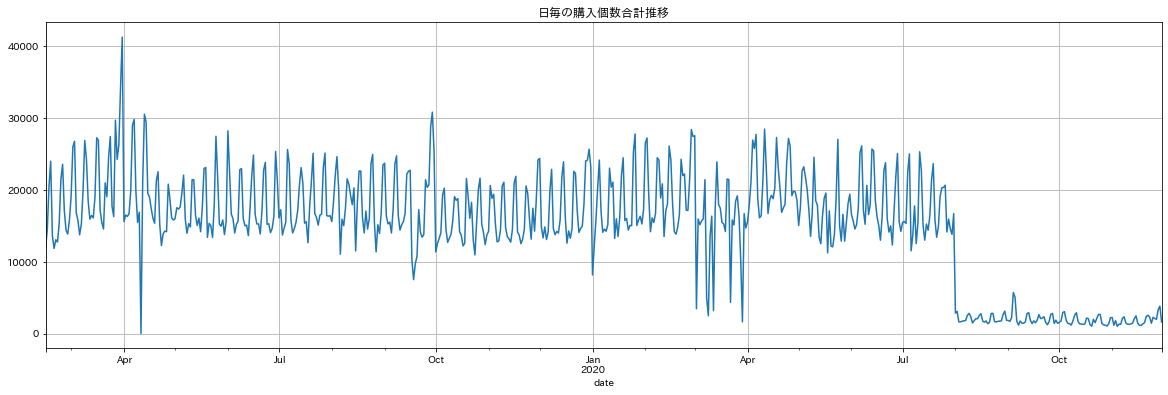

In [6]:
# 日毎の購入点数の推移
fig, ax = plt.subplots(figsize=(20,6))
log_df.groupby("date")["n_items"].sum().plot(ax=ax)
ax.grid()
ax.set_title("日毎の購入個数合計推移")

### 購入者と未購入者で、購入個数に差はあるか

In [5]:
# 購入したlogだけに絞る関数
def filter_payment_logs(log_df):
    x = log_df.groupby("session_id")["is_payment"].sum() # session_id単位で、paymentを合計
    payment_sessions = x[x>0].index  # pyamentがあるsession_idのリスト
    idx = log_df["session_id"].isin(payment_sessions) # isinはbool値を返す
    payment_log_df = log_df[idx].reset_index(drop=True)  # Trueのものだけを返す
    return payment_log_df

In [6]:
filter_payment_logs(log_df).session_id.nunique()

618462

In [7]:
log_df.session_id.nunique()

720175

In [8]:
payed_log_df = filter_payment_logs(log_df)

In [9]:
# log_dfのなかでの最大/最小の範囲での連続した日付を取得（その後、それをindexに適応）
date_index = pd.date_range(log_df["date"].min(), log_df["date"].max())

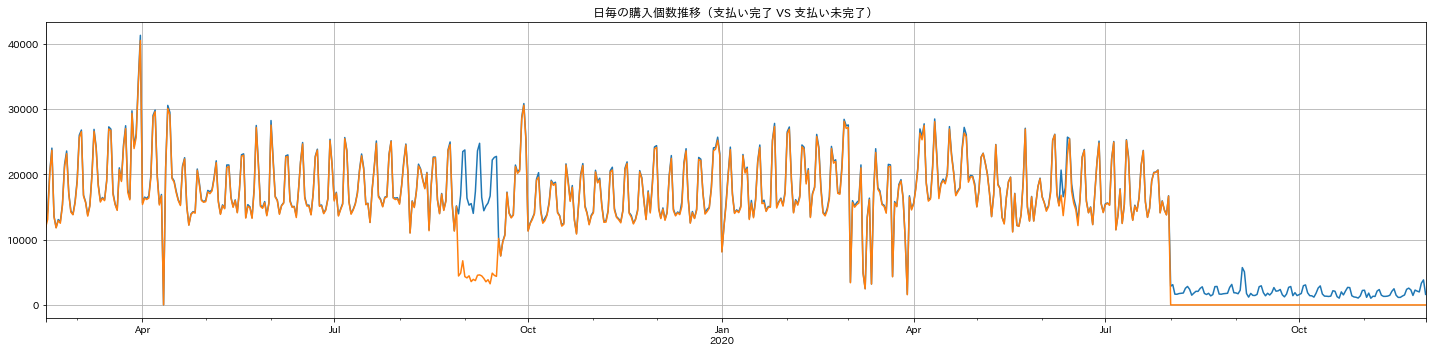

In [10]:
fig, ax = plt.subplots(figsize=(20,5))
log_df.groupby("date")["n_items"].sum().reindex(date_index).fillna(0).plot(ax=ax)
payed_log_df.groupby("date")["n_items"].sum().reindex(date_index).fillna(0).plot(ax=ax)
ax.grid()
ax.set_title("日毎の購入個数推移（支払い完了 VS 支払い未完了）")
fig.tight_layout()

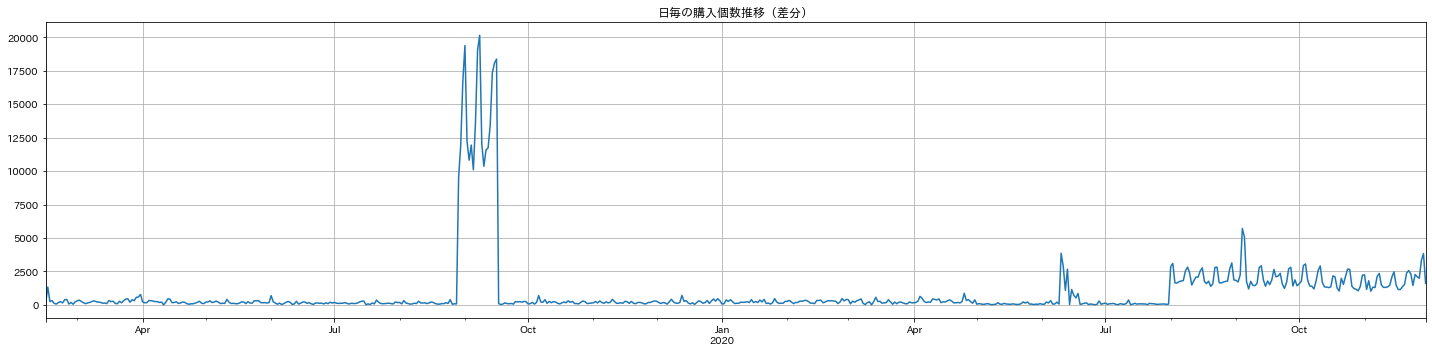

In [11]:
fig, ax = plt.subplots(figsize=(20,5))
all_ = log_df.groupby("date")["n_items"].sum().reindex(date_index).fillna(0)
payed_ = payed_log_df.groupby("date")["n_items"].sum().reindex(date_index).fillna(0)
(all_ - payed_).plot(ax=ax)
ax.grid()
ax.set_title("日毎の購入個数推移（差分）")
fig.tight_layout()

### 曜日/時間ごとの購入件数に傾向差はあるか？

In [12]:
payed_log_df.groupby(payed_log_df["date"].dt.dayofweek)["n_items"].sum().plot(kind="bar")

<AxesSubplot:xlabel='date'>

In [13]:
payed_log_df.groupby("hour")["n_items"].sum().plot(kind="bar")

<AxesSubplot:xlabel='hour'>

### kind_1の内訳はどうなっているか

In [16]:
payed_log_df.groupby("kind_1").size().sort_values().plot(kind="barh")

<AxesSubplot:ylabel='kind_1'>

### display_actionの出現傾向

In [14]:
display_action_df = pd.read_csv(os.path.join(INPUT_DIR, "display_action_id.csv"))

In [15]:
display_action_df.head()

display_action_id   論理名 display_name  action_name
0                  8  クーポン      クーポンPOP       クーポン発券
1                  9  クーポン      クーポンPOP  クーポン発券(POP)
2                 11  クーポン      クーポンPOP         自動表示
3                 14  クーポン       クーポン一覧       カテゴリ選択
4                 20  クーポン       クーポン一覧       クーポン発券

In [16]:
display_action = display_action_df["display_name"] + "_" + display_action_df["action_name"]
displayactionid2name = dict(zip(display_action_df["display_action_id"], display_action)) 

<AxesSubplot:xlabel='display_action_id'>

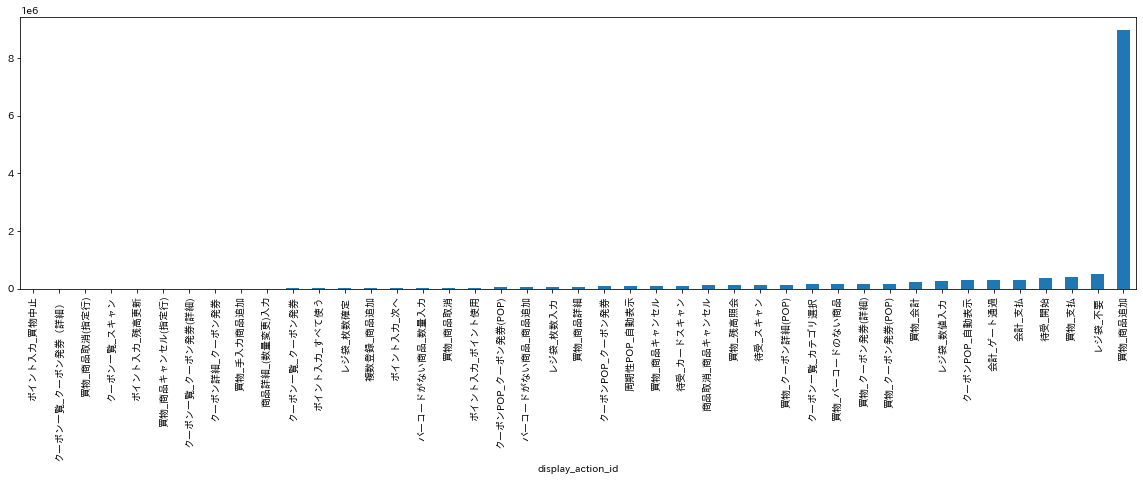

In [17]:
fig, ax = plt.subplots(figsize=(20,5))
df_ = payed_log_df.groupby("display_action_id").size().sort_values()
df_.index = df_.index.map(displayactionid2name)
df_.plot(kind="bar", ax=ax)

### 時間帯ごとのdisplay_actionの傾向（分母：時間帯ごとの合計）

In [21]:
df_ = pd.pivot_table(data=payed_log_df,
                    index="hour",
                    columns="display_action_id",
                    values="n_items",
                    aggfunc="size")
df_.columns = df_.columns.map(displayactionid2name)

In [22]:
df_.sum(axis="columns")

hour
0       14428.0
1        7682.0
2        3899.0
3        2998.0
4        5391.0
5       60933.0
6      108867.0
7      150809.0
8      185995.0
9      594074.0
10     921035.0
11    1107250.0
12    1044582.0
13    1002525.0
14    1158845.0
15    1317922.0
16    1374752.0
17    1412540.0
18    1251589.0
19     855233.0
20     595184.0
21     298832.0
22     169511.0
23      69330.0
dtype: float64

<AxesSubplot:xlabel='display_action_id', ylabel='hour'>

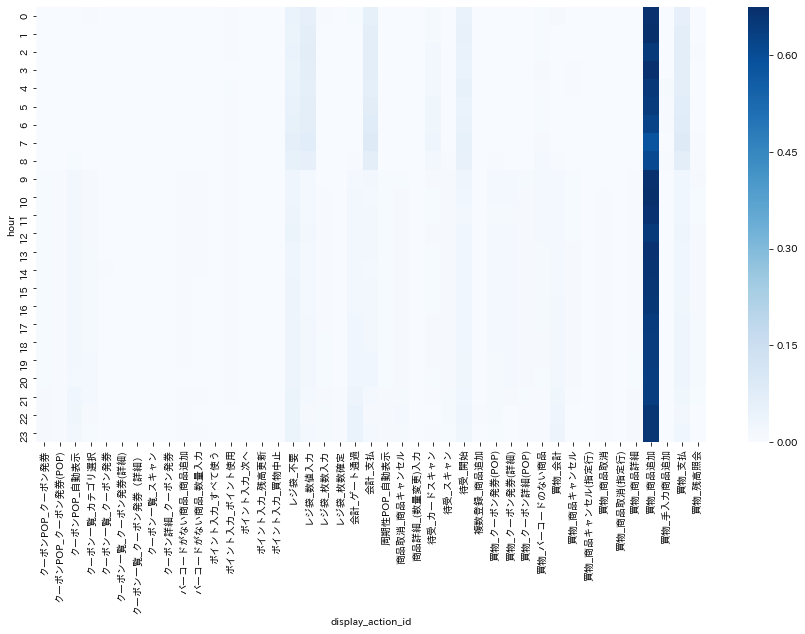

In [23]:
# その時間帯の合計値で正規化
df_ = df_.div(df_.sum(axis="columns"), axis="index").fillna(0)

fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(df_, ax=ax, cmap="Blues")

### 上記で、「商品追加」を除いたときの傾向

<AxesSubplot:xlabel='display_action_id', ylabel='hour'>

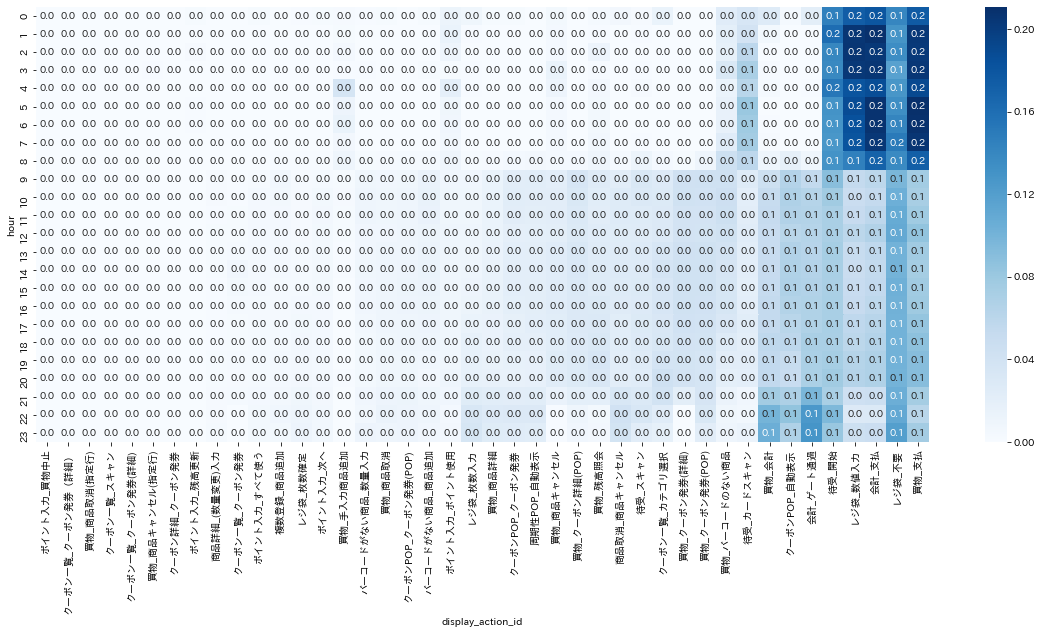

In [24]:
_idx = payed_log_df["display_action_id"] != 209

df_ = pd.pivot_table(data=payed_log_df[_idx],
                    index="hour",
                    columns="display_action_id",
                    values="n_items",
                    aggfunc="size")
df_.columns = df_.columns.map(displayactionid2name)

df_ = df_.div(df_.sum(axis="columns"), axis="index").fillna(0)

# 合計割合の多いdisplay_actionでsortして、そのindexを取得している
order = np.argsort(df_.sum())

fig, ax = plt.subplots(figsize=(20,8))
sns.heatmap(df_.iloc[:,order], ax=ax, cmap="Blues", annot=True, fmt=".1f")

In [25]:
df_.sum()

display_action_id
クーポンPOP_クーポン発券         0.325522
クーポンPOP_クーポン発券(POP)    0.156687
クーポンPOP_自動表示           0.993992
クーポン一覧_カテゴリ選択          0.501771
クーポン一覧_クーポン発券          0.042656
クーポン一覧_クーポン発券(詳細)      0.005592
クーポン一覧_クーポン発券（詳細）      0.000198
クーポン一覧_スキャン            0.003285
クーポン詳細_クーポン発券          0.008410
バーコードがない商品_商品追加        0.175269
バーコードがない商品_数量入力        0.122074
ポイント入力_すべて使う           0.067100
ポイント入力_ポイント使用          0.214211
ポイント入力_次へ              0.084523
ポイント入力_残高更新            0.012271
ポイント入力_買物中止            0.000032
レジ袋_不要                 2.782741
レジ袋_数値入力               2.451821
レジ袋_枚数入力               0.251598
レジ袋_枚数確定               0.082333
会計_ゲート通過               1.172684
会計_支払                  2.626140
周期性POP_自動表示            0.332512
商品取消_商品キャンセル           0.421168
商品詳細_(数量変更)入力          0.030836
待受_カードスキャン             0.853630
待受_スキャン                0.440843
待受_開始                  2.396462
複数登録_商品追加              0.077211
買物_クーポン発券(POP)         0.578404
買物_クーポン発券(詳細)         

In [26]:
session_id = payed_log_df[payed_log_df['hour'] < 8]['session_id'].sample(1).values[0]
payed_log_df.query('session_id == @session_id')

session_id  register_number       date  hour  spend_time  \
5482967      277995             2002 2019-08-26     7           0   
5482968      277995             2002 2019-08-26     7          13   
5482969      277995             2002 2019-08-26     7          20   
5482970      277995             2002 2019-08-26     7          28   
5482971      277995             2002 2019-08-26     7          33   
5482972      277995             2002 2019-08-26     7          39   
5482973      277995             2002 2019-08-26     7          43   
5482974      277995             2002 2019-08-26     7          46   
5482975      277995             2002 2019-08-26     7          49   
5482976      277995             2002 2019-08-26     7          51   
5482977      277995             2002 2019-08-26     7          53   
5482978      277995             2002 2019-08-26     7          56   

         display_action_id                 user_id        value_1  \
5482967                141                     NaN            NaN   
5482968                209  6L6j9s8TBVCDMYSSTLNabh  4908649511573   
5482969                209  6L6j9s8TBVCDMYSSTLNabh  4908649511573   
5482970                209  6L6j9s8TBVCDMYSSTLNabh  4522646702873   
5482971                209  6L6j9s8TBVCDMYSSTLNabh  4901525006293   
5482972                209  6L6j9s8TBVCDMYSSTLNabh  4571268298479   
5482973                209  6L6j9s8TBVCDMYSSTLNabh       49335989   
5482974                209  6L6j9s8TBVCDMYSSTLNabh  2504174000000   
5482975                218  6L6j9s8TBVCDMYSSTLNabh            NaN   
5482976                 77  6L6j9s8TBVCDMYSSTLNabh              0   
5482977                 73  6L6j9s8TBVCDMYSSTLNabh  4522646330991   
5482978                105  6L6j9s8TBVCDMYSSTLNabh            NaN   

                    name_1 kind_1  number_1  value_2 name_2 kind_2  number_2  \
5482967                NaN    NaN       NaN      NaN    NaN    NaN       NaN   
5482968      アップルジュース　100％     商品       1.0      NaN    NaN    NaN       NaN   
5482969      アップルジュース　100％     商品       1.0      NaN    NaN    NaN       NaN   
5482970          PB緑茶500ml     商品       1.0      NaN    NaN    NaN       NaN   
5482971  ﾐﾙｷｨﾎﾞﾃﾞｨやさしい石鹸替え     商品       1.0      NaN    NaN    NaN       NaN   
5482972       うす焼ピッツァ　トマトと     商品       1.0      NaN    NaN    NaN       NaN   
5482973       朝食アロエ＆白ぶどうヨー     商品       1.0      NaN    NaN    NaN       NaN   
5482974        梅ひじきおにぎり２個入     商品       1.0      NaN    NaN    NaN       NaN   
5482975                NaN    NaN       NaN      NaN    NaN    NaN       NaN   
5482976                NaN     キー       NaN      NaN    NaN    NaN       NaN   
5482977                レジ袋     商品       0.0      NaN    NaN    NaN       NaN   
5482978                NaN    NaN       NaN      NaN    NaN    NaN       NaN   

         unit_price  n_items  is_payment  
5482967         NaN        0           0  
5482968       105.0        1           0  
5482969       105.0        1           0  
5482970        49.0        1           0  
5482971       179.0        1           0  
5482972       219.0        1           0  
5482973        99.0        1           0  
5482974        98.0        1           0  
5482975         NaN        0           0  
5482976         NaN        0           0  
5482977         NaN        0           0  
5482978         NaN        0           1

### 年月ごとの傾向

In [27]:
month = payed_log_df['date'].dt.month.rename('month')
year = payed_log_df['date'].dt.year.rename('year')
_df = pd.pivot_table(payed_log_df, 
                     index='hour',
                     columns=[year, month], 
                     values='is_payment', 
                     aggfunc='sum').fillna(0)

In [28]:
_df

year     2019                                                                  \
month      2       3       4       5       6       7       8       9       10   
hour                                                                            
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     2.0   161.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   106.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    63.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    46.0   
4         3.0    18.0    15.0    18.0    13.0    11.0    13.0     8.0    67.0   
5       246.0   514.0   437.0   423.0   565.0   671.0   584.0   460.0   170.0   
6       365.0   875.0   872.0   943.0  1009.0  1105.0  1139.0   915.0   322.0   
7       577.0  1234.0  1269.0  1424.0  1445.0  1624.0  1854.0  1334.0   476.0   
8       534.0  1241.0  1229.0  1481.0  1302.0  1515.0  1340.0  1284.0   540.0   
9       596.0  1531.0  1384.0  1508.0  1499.0  1601.0  1447.0   917.0  1266.0   
10      895.0  2450.0  2215.0  2228.0  2178.0  2310.0  2143.0  1231.0  1950.0   
11     1275.0  3505.0  2801.0  2868.0  2775.0  2947.0  2775.0  1550.0  2447.0   
12     1391.0  3475.0  2907.0  2945.0  3017.0  3076.0  2982.0  1935.0  2646.0   
13     1263.0  3110.0  2513.0  2530.0  2548.0  2563.0  2285.0  1443.0  2256.0   
14     1395.0  3480.0  2784.0  2773.0  2853.0  2752.0  2598.0  1599.0  2598.0   
15     1624.0  3940.0  3384.0  3324.0  3300.0  3366.0  3006.0  1883.0  3133.0   
16     1718.0  4341.0  3744.0  3727.0  3681.0  3534.0  3365.0  1931.0  3292.0   
17     1910.0  4632.0  4025.0  4138.0  4135.0  4176.0  3789.0  2181.0  3634.0   
18     1714.0  4267.0  3693.0  3831.0  3723.0  3999.0  3614.0  2090.0  3414.0   
19     1205.0  2813.0  2694.0  2849.0  2731.0  3018.0  2847.0  1541.0  2288.0   
20      735.0  1925.0  1849.0  1991.0  2059.0  2173.0  1964.0  1121.0  1575.0   
21      216.0   633.0   617.0   603.0   597.0   622.0   577.0   476.0  1112.0   
22        0.0     1.0     0.0     0.0     0.0     1.0    75.0   261.0   939.0   
23        0.0     0.0     0.0     0.0     0.0     0.0    47.0   119.0   419.0   

year                     2020                                                  
month      11      12      1       2       3       4       5       6       7   
hour                                                                           
0       144.0   191.0   143.0   117.0    36.0    69.0    21.0    24.0    51.0  
1        99.0   119.0    88.0    57.0    15.0    15.0    11.0     3.0    11.0  
2        69.0    69.0    44.0    20.0     2.0     6.0     1.0     2.0     1.0  
3        38.0    58.0    32.0    23.0     0.0     0.0     2.0     2.0     1.0  
4        46.0    73.0    46.0    15.0     0.0     1.0     1.0     3.0     2.0  
5       142.0   147.0    71.0    39.0     0.0     5.0     5.0     9.0     9.0  
6       275.0   225.0   146.0    84.0    23.0    51.0    18.0    23.0    27.0  
7       382.0   340.0   235.0   185.0    74.0   102.0    43.0    78.0   109.0  
8       525.0   506.0   343.0   369.0   174.0   214.0    64.0   146.0   190.0  
9      1157.0  1195.0  1131.0  1220.0   912.0  1340.0   994.0  1212.0  1268.0  
10     1865.0  1894.0  1845.0  2063.0  1618.0  2357.0  2057.0  2079.0  2153.0  
11     2329.0  2534.0  2544.0  2653.0  2143.0  3005.0  2608.0  2589.0  2554.0  
12     2580.0  2856.0  2848.0  2776.0  2077.0  2733.0  2232.0  2479.0  2352.0  
13     2255.0  2369.0  2305.0  2465.0  1822.0  2453.0  1981.0  2059.0  2188.0  
14     2512.0  2766.0  2683.0  2844.0  2251.0  2804.0  2488.0  2550.0  2546.0  
15     3147.0  3296.0  3440.0  3396.0  2607.0  3174.0  2838.0  2924.0  3041.0  
16     3349.0  3506.0  3781.0  3639.0  2822.0  3282.0  2960.0  3146.0  3226.0  
17     3739.0  3788.0  3991.0  3920.0  3116.0  3349.0  3151.0  3519.0  3445.0  
18     3483.0  3488.0  3615.0  3772.0  2947.0  3406.0  2990.0  3332.0  3268.0  
19     2234.0  2316.0  2428.0  2447.0  1953.0  2396.

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
_df.sum().plot(ax=ax)

<AxesSubplot:xlabel='year,month'>

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(_df.apply(np.log1p), cmap="Blues", ax=ax, annot=True, fmt=".1f")

<AxesSubplot:xlabel='year-month', ylabel='hour'>

<AxesSubplot:xlabel='display_action_id', ylabel='hour'>

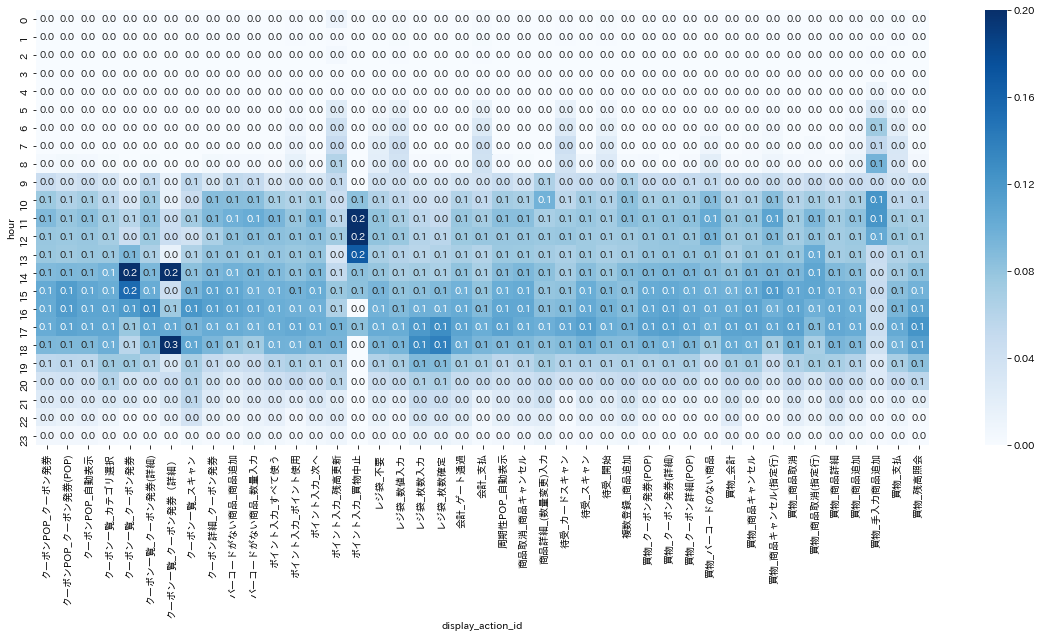

In [31]:
_df = pd.pivot_table(data=payed_log_df, 
                     index='hour', 
                     columns='display_action_id', 
                     values='n_items', 
                     aggfunc='size')

# アクションごとで正規化
_df = _df.div(_df.sum(axis=0), axis=1).fillna(0)

# 日本語化
_df.columns = _df.columns.map(displayactionid2name)

# ヒートマップ
# 「vmax=.2」で色合いの最大値を0.2までにキャップかけて、見やすくしている
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(_df, ax=ax, cmap='Blues', annot=True, fmt='.1f', vmax=.2)

## meta.csvについてEDA

In [18]:
meta_df = pd.read_csv(os.path.join(INPUT_DIR, "meta.csv"), parse_dates=["date"])
meta_df.head()

session_id                 user_id       date  hour  register_number  \
0           0  bE94Gct4vGiKM7z2Y79cjk 2019-02-14     4             2003   
1           1  V4bEuaKPEPoK8MswqPksvK 2019-02-14     4             2006   
2           2  ntRurFKVWYBQR86auef5Fc 2019-02-14     5             2001   
3           3  GhHaHMCyrz76y2dCeVXfbn 2019-02-14     5             2001   
4           4  kG58HejrEcbjJQ7JojRSay 2019-02-14     5             2002   

   time_elapsed  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [33]:
meta_df.register_number.nunique()

223

In [34]:
meta_df.groupby("register_number").size().sort_values()[:30].plot(kind="bar", figsize=(20,5))

<AxesSubplot:xlabel='register_number'>

In [35]:
meta_df.query('register_number == 1140').shape[0]

10

## product_master.csvについてEDA

In [19]:
product_master_df = pd.read_csv(os.path.join(INPUT_DIR, "product_master.csv"), dtype={"JAN":str})
product_master_df.sample(5)

JAN                       商品名  部門CD        部門名  カテゴリCD  \
1389702  4945647907649                   ジョガーパンツ    71  レディースアウター       1   
1503269  4959418463920  cool　maxｶﾗｰ・ﾃﾞﾆﾑｽｷﾆｰﾊﾟﾝﾂ    71  レディースアウター       1   
270726   2800030230464                   和風弁当シール   139  TPL（サービス）      91   
644367   4548231529649      R-4266ﾌﾟﾗｳﾄﾞWBｼﾞｬｹｯﾄ    30       スポーツ       6   
660722   4548631885680             べすと付ぼーだーちゅにっく    72    キッズアウター      13   

            カテゴリ名  サブカテゴリCD  サブカテゴリ名  セグメントCD セグメント名  サブセグメントCD サブセグメント名  \
1389702     ベーシック        13  レギンスパンツ        1     無地          2     アンクル   
1503269     ベーシック        11      パンツ        4  ストレート          1      デニム   
270726         包材         3      ラベル       99    その他         99      その他   
644367   スポーツブランド        99      その他       99    その他         99      その他   
660722     女児トップス         3    トレーナー        1  998まで         98     設定なし   

            category_name  category_id  
1389702  レディースアウター__ベーシック          246  
1503269  レディースアウター__ベーシック          246  
270726      TPL（サービス）__包材           18  
644367     スポーツ__スポーツブランド          117  
660722    キッズアウター__女児トップス           68

In [20]:
TARGET_CATEGORIES = [
    # お酒に関するもの
    'ビール系__RTD', 'ビール系__ビール系', 'ビール系__ノンアルコール',
    
    # お菓子に関するもの
    'スナック・キャンディー__スナック', 
    'チョコ・ビスクラ__チョコレート', 
    'スナック・キャンディー__ガム', 
    'スナック・キャンディー__シリアル',
    'アイスクリーム__ノベルティー', 
    '和菓子__米菓',
    
    # 飲料に関するもの
    '水・炭酸水__大型PET（炭酸水）',
    '水・炭酸水__小型PET（炭酸水）',
    '缶飲料__コーヒー（缶）',
    '小型PET__コーヒー（小型PET）',
    '大型PET__無糖茶（大型PET）',
    
    # 麺類
    '麺類__カップ麺',
]

In [38]:
len(product_master_df)

1965937

In [39]:
for target_category in TARGET_CATEGORIES:
    print(f"{target_category}: {product_master_df.query('category_name == @target_category').shape[0]}")

ビール系__RTD: 5562
ビール系__ビール系: 4751
ビール系__ノンアルコール: 587
スナック・キャンディー__スナック: 6471
チョコ・ビスクラ__チョコレート: 6072
スナック・キャンディー__ガム: 2008
スナック・キャンディー__シリアル: 1315
アイスクリーム__ノベルティー: 3467
和菓子__米菓: 3633
水・炭酸水__大型PET（炭酸水）: 74
水・炭酸水__小型PET（炭酸水）: 253
缶飲料__コーヒー（缶）: 2123
小型PET__コーヒー（小型PET）: 402
大型PET__無糖茶（大型PET）: 745
麺類__カップ麺: 4932


In [40]:
_df = product_master_df.groupby(['category_name']).agg(['nunique'])
_df

JAN     商品名    部門CD     部門名  カテゴリCD   カテゴリ名 サブカテゴリCD  \
              nunique nunique nunique nunique nunique nunique  nunique   
category_name                                                            
100円均一__その他     76413   74390       1       1       1       1        1   
100円均一__キッチン     9939    9866       1       1       1       1        8   
100円均一__シーズン     7631    7126       1       1       1       1        7   
100円均一__スポット      708     708       1       1       1       1        1   
100円均一__バラエティ   14231   14053       1       1       1       1       10   
...               ...     ...     ...     ...     ...     ...      ...   
鶏肉__骨付もも          123      87       1       1       1       1        4   
麺類__カップ麺         4932    4599       1       1       1       1        2   
麺類__パスタ          1151    1058       1       1       1       1        4   
麺類__乾麺・半生麺・棒麺    1522    1321       1       1       1       1        8   
麺類__袋麺            972     918       1       1       1       1        2   

              サブカテゴリ名 セグメントCD  セグメント名 サブセグメントCD サブセグメント名 category_id  
              nunique nunique nunique   nunique  nunique     nunique  
category_name                                                         
100円均一__その他         1       1       1         1        1           1  
100円均一__キッチン        8      14      37        15      212           1  
100円均一__シーズン        7      18      24         6       27           1  
100円均一__スポット        1      16      16         2        8           1  
100円均一__バラエティ      10      16      44        13      144           1  
...               ...     ...     ...       ...      ...         ...  
鶏肉__骨付もも            4       1       1        12       12           1  
麺類__カップ麺            2       2       2         6        6           1  
麺類__パスタ             4       3       8         5       17           1  
麺類__乾麺・半生麺・棒麺       8       7      15         5       25           1  
麺類__袋麺              2       2       2         6        6           1  

[772 rows x 13 columns]

In [41]:
"_".join(_df.columns[0])

'JAN_nunique'

In [42]:
"_".join(["a","b","c"])

'a_b_c'

In [43]:
# csvで吐き出して、スプシで眺めてみる
_df.columns = ["_".join(c) for c in _df.columns]
_df.to_csv(os.path.join(REFE_DIR, "category_info.csv"))

## 学習の枠組みをつくる 
- スライドでも紹介したように学習のため先頭 T 時間だけ見えるような学習用のログデータを作成する必要があります
- やりたいことはセッションごとの特定の時間までのデータを取り出す、ということです。
- 簡単に行なうのであればセッションと経過時間 (session_id spend_time の2つ)でソートしたあと、セッションごとの先頭 N 行を取り出す方法があります。
- 最初に並び替えを行ったあとに先頭のNを取り出しますので、経過時間でみた時のはじめのN個を取ることが可能です。

In [44]:
product_master_df.head()

JAN      商品名  部門CD   部門名  カテゴリCD    カテゴリ名  サブカテゴリCD  サブカテゴリ名  セグメントCD  \
0   1  テナント商品1    98  未登録等      99  未登録等その他        99  未登録等その他       99   
1   2  テナント商品2    98  未登録等      99  未登録等その他        99  未登録等その他       99   
2   3  テナント商品3    98  未登録等      99  未登録等その他        99  未登録等その他       99   
3   4  テナント商品4    98  未登録等      99  未登録等その他        99  未登録等その他       99   
4   5  テナント商品5    98  未登録等      99  未登録等その他        99  未登録等その他       99   

  セグメント名  サブセグメントCD サブセグメント名  category_name  category_id  
0    その他         99      その他  未登録等__未登録等その他          517  
1    その他         99      その他  未登録等__未登録等その他          517  
2    その他         99      その他  未登録等__未登録等その他          517  
3    その他         99      その他  未登録等__未登録等その他          517  
4    その他         99      その他  未登録等__未登録等その他          517

In [21]:
cat2id = dict(zip(product_master_df["category_name"], product_master_df["category_id"]))
TARGET_IDS = pd.Series(TARGET_CATEGORIES).map(cat2id).values.tolist()
for i in zip(TARGET_IDS, TARGET_CATEGORIES):
    print(i)

(171, 'ビール系__RTD')
(173, 'ビール系__ビール系')
(172, 'ビール系__ノンアルコール')
(114, 'スナック・キャンディー__スナック')
(134, 'チョコ・ビスクラ__チョコレート')
(110, 'スナック・キャンディー__ガム')
(113, 'スナック・キャンディー__シリアル')
(38, 'アイスクリーム__ノベルティー')
(376, '和菓子__米菓')
(537, '水・炭酸水__大型PET（炭酸水）')
(539, '水・炭酸水__小型PET（炭酸水）')
(629, '缶飲料__コーヒー（缶）')
(467, '小型PET__コーヒー（小型PET）')
(435, '大型PET__無糖茶（大型PET）')
(768, '麺類__カップ麺')


In [22]:
def create_payment(input_df):
    """
    ログデータから　session_id / JAN ごとの購買情報に変換します

    Args（引数）:
        input_df:
            レジカートログデータ

    Returns:
        session_id, JAN, n_items(合計購買数)のDataFrame    
    """

    idx = input_df["kind_1"] == "商品"
    out_df = input_df[idx].reset_index(drop=True)

    out_df = out_df.groupby(["session_id", "value_1"])["n_items"].sum().reset_index()
    out_df = out_df.rename(columns={"value_1": "JAN"})
    return out_df

In [23]:
def only_payment_session_record(input_log_df):
    """
    支払いが紐づくセッションのみに絞り込みを行う
    """
    payed_sessions = input_log_df[input_log_df["is_payment"]==1]["session_id"].unique()
    idx = input_log_df["session_id"].isin(payed_sessions) # bool値
    out_df = input_log_df[idx].reset_index(drop=True)
    return out_df

In [24]:
s1 = set(log_df["value_1"].unique())
s2 = set(product_master_df["JAN"].unique())
venn2(subsets=[s1,s2],set_labels=["log_df","product_master_df"])

In [25]:
def annot_category(input_df, master_df):
    """
    カテゴリーIDを紐付ける
    """
    if master_df["JAN"].dtype !="str":
        master_df["JAN"] = master_df["JAN"].astype("str")

    input_df = input_df.rename(columns={"value_1":"JAN"})
    out_df = pd.merge(input_df["JAN"],
                master_df[["JAN","category_id"]], on="JAN", how="left")
    return out_df["category_id"]

In [26]:
# Nanが交じると、float型になる
annot_category(log_df,product_master_df)

0             NaN
1           617.0
2           617.0
3           617.0
4           617.0
            ...  
14632770    771.0
14632771    771.0
14632772      NaN
14632773    184.0
14632774    134.0
Name: category_id, Length: 14632775, dtype: float64

In [27]:
def create_target_from_log(log_df,
                            product_master_df,
                            only_payment = True,
                            target_flg = True):
    """
    targetとなるcategory_idそれぞれを購入したかの合計値（Not bool値）が
    カラムとなったdataframeを出力する
    """

    if only_payment:
        log_df = only_payment_session_record(log_df)
    
    pay_df = create_payment(log_df)
    pay_df["category_id"] = annot_category(pay_df,product_master_df)

    # nullのcategoryを削除（JANが紐付かないときに発生する）
    idx_null = pay_df["category_id"].isnull()
    pay_df = pay_df[~idx_null].reset_index(drop=True)

    # nullが混じっているとfloat型になるので、int型に型変換する
    pay_df["category_id"] = pay_df["category_id"].astype(int)

    if target_flg:
        idx = pay_df["category_id"].isin(TARGET_IDS)
    else:
        idx = [True]*pay_df.shape[0]
    
    target_df = pd.pivot_table(data=pay_df[idx],
                                index="session_id",
                                columns="category_id",
                                values="n_items",
                                aggfunc="sum")

    sessions = sorted(log_df["session_id"].unique())
    target_df = target_df.reindex(sessions) # 抜けてるsession_idを補完
    target_df = target_df.fillna(0).astype(int)

    return target_df, pay_df

In [28]:
# セッションごとに時間が速い順に並び替える
payed_log_df = payed_log_df.sort_values(["session_id","spend_time"]).reset_index(drop=True)

# session_idごとの先頭N行を取得する（これをpublicとする）
# こちらが学習データ？
N = 5
public_log_df = payed_log_df.groupby("session_id").head(N)

# 取得されたデータのINDEX == 見えてもよいログのINDEX
show_log_indexes = public_log_df.index
show_idxs = pd.Index(payed_log_df.index.isin(show_log_indexes))

In [29]:
# 反対（==False）の部分はみえたら駄目な部分
# こちらが目的変数をつくるためのデータ？
private_log_df = payed_log_df.iloc[show_idxs == False].reset_index(drop=True)

In [30]:
payed_log_df.shape, public_log_df.shape, private_log_df.shape

((13714206, 18), (3091168, 18), (10623038, 18))

In [31]:
private_log_df.head()

session_id  register_number       date  hour  spend_time  \
0           0             2003 2019-02-14     4          72   
1           0             2003 2019-02-14     4          81   
2           0             2003 2019-02-14     4          86   
3           0             2003 2019-02-14     4         133   
4           0             2003 2019-02-14     4         140   

   display_action_id                 user_id        value_1    name_1 kind_1  \
0                209  bE94Gct4vGiKM7z2Y79cjk  4522646720440  ツナマヨおにぎり     商品   
1                218  bE94Gct4vGiKM7z2Y79cjk            NaN       NaN    NaN   
2                 73  bE94Gct4vGiKM7z2Y79cjk  4522646330991       レジ袋     商品   
3                 59  bE94Gct4vGiKM7z2Y79cjk            NaN       NaN    NaN   
4                105  bE94Gct4vGiKM7z2Y79cjk            NaN       NaN    NaN   

   number_1  value_2 name_2 kind_2  number_2  unit_price  n_items  is_payment  
0       1.0      NaN    NaN    NaN       NaN        79.0        1           0  
1       NaN      NaN    NaN    NaN       NaN         NaN        0           0  
2       0.0      NaN    NaN    NaN       NaN         NaN        0           0  
3       NaN      NaN    NaN    NaN       NaN         NaN        0           0  
4       NaN      NaN    NaN    NaN       NaN         NaN        0           1

In [32]:
# 見えたら駄目なデータを使ってターゲットの集計を行う（create_target_from_log 関数）
# これを学習時のラベル（目的変数）とする！！！
train_n_target_df, _ = create_target_from_log(private_log_df,product_master_df)

In [33]:
# おー目的変数ラベルできてる！
train_n_target_df.tail(10)

category_id  38   110  113  114  134  171  172  173  376  435  467  537  539  \
session_id                                                                     
663697         0    0    0    0    0    0    0    0    0    0    0    0    0   
663698         0    0    0    0    0    0    0    0    0    0    0    0    0   
663699         0    0    0    1    0    0    0    0    1    0    0    0    0   
663700         3    0    0    2    0    0    0    0    0    0    0    0    0   
663701         0    0    0    0    0    1    0    2    0    0    0    0    0   
663703         0    0    0    0    0    0    0    0    0    1    0    0    0   
663704         0    0    0    0    0    0    0    0    0    0    0    0    0   
663705         0    0    0    0    0    0    0    0    0    0    0    0    0   
663706         0    0    0    0    0    0    0    0    0    0    0    0    0   
663707         0    0    0    0    0    0    0    0    0    0    0    0    0   

category_id  629  768  
session_id             
663697         0    0  
663698         0    0  
663699         0    0  
663700         0    0  
663701         0    0  
663703         0    0  
663704         0    0  
663705         0    0  
663706         0    0  
663707         0    1

In [34]:
# 集計が個数単位なので、買ったか否かのbool値に変換
train_target_df = train_n_target_df.mask(train_n_target_df>0,1)

# 一部、値がマイナスのものがある（-1,-2）ため、マイナスは「０」にならす
train_target_df = train_target_df.mask(train_n_target_df<0,0)

In [35]:
train_target_df.tail(10)

category_id  38   110  113  114  134  171  172  173  376  435  467  537  539  \
session_id                                                                     
663697         0    0    0    0    0    0    0    0    0    0    0    0    0   
663698         0    0    0    0    0    0    0    0    0    0    0    0    0   
663699         0    0    0    1    0    0    0    0    1    0    0    0    0   
663700         1    0    0    1    0    0    0    0    0    0    0    0    0   
663701         0    0    0    0    0    1    0    1    0    0    0    0    0   
663703         0    0    0    0    0    0    0    0    0    1    0    0    0   
663704         0    0    0    0    0    0    0    0    0    0    0    0    0   
663705         0    0    0    0    0    0    0    0    0    0    0    0    0   
663706         0    0    0    0    0    0    0    0    0    0    0    0    0   
663707         0    0    0    0    0    0    0    0    0    0    0    0    0   

category_id  629  768  
session_id             
663697         0    0  
663698         0    0  
663699         0    0  
663700         0    0  
663701         0    0  
663703         0    0  
663704         0    0  
663705         0    0  
663706         0    0  
663707         0    1

In [36]:
# public（先頭5行）のうち、先頭が5行未満のものは目的変数がない
# なので、そのsession_idは除外
train_sessions = train_target_df.index.values
idx = public_log_df["session_id"].isin(train_sessions)
public_log_df = public_log_df[idx].reset_index(drop=True)

In [37]:
s1 = set(public_log_df["session_id"].unique())
s2 = set(train_sessions)
venn2(subsets=[s1,s2],set_labels=["public_log_df","train_sessions"])

## Testデータの確認

In [38]:
test_df = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
test_df.head()

session_id
0      663721
1      663725
2      663737
3      663745
4      663747

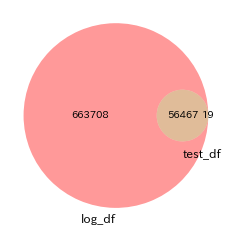

In [63]:
s1 = set(log_df["session_id"].unique())
s2 = set(test_df["session_id"].unique())
venn2(subsets=[s1,s2], set_labels=["log_df","test_df"])

In [64]:
# public_log_df は購入flg＝１のなかから、head5行あるものに絞っているので、testとは重ならない
s1 = set(public_log_df["session_id"].unique())
s2 = set(test_df["session_id"].unique())
venn2(subsets=[s1,s2], set_labels=["public_log_df","test_df"])

In [64]:
# test_dfのlogデータ
idx = log_df["session_id"].isin(test_df["session_id"])
test_log_df = log_df[idx].reset_index(drop=True)

# public_log_df と test_dfのlogデータを結合
use_for_train_log_df = pd.concat([public_log_df,test_log_df],ignore_index=True)

### test_dfのなかで、logがないsession_id

In [66]:
set(test_df["session_id"]) - set(use_for_train_log_df["session_id"].unique())

{682349,
 704830,
 725208,
 728928,
 729398,
 729451,
 733798,
 745110,
 747729,
 748642,
 750380,
 750607,
 757008,
 760324,
 763591,
 770159,
 771067,
 775245,
 790037}

## 特徴量エンジニアリング

In [39]:
# 目的変数がある session_id 
train_df = pd.DataFrame({"session_id":train_sessions})

In [40]:
# train_df と mergeするための関数をつくっておく
# 何度も書くものは、関数化しておく（by GOTOさん）
def merge_by_session_id(left_df, right_df, drop_session_id = True):
    out_df = pd.merge(left_df, right_df, on="session_id", how="left")
    if drop_session_id: # 自分で付け加えたパーツ（GOOD!!!!）
        out_df = out_df.drop(columns=["session_id"])
    return out_df

In [41]:
meta_df.head()

session_id                 user_id       date  hour  register_number  \
0           0  bE94Gct4vGiKM7z2Y79cjk 2019-02-14     4             2003   
1           1  V4bEuaKPEPoK8MswqPksvK 2019-02-14     4             2006   
2           2  ntRurFKVWYBQR86auef5Fc 2019-02-14     5             2001   
3           3  GhHaHMCyrz76y2dCeVXfbn 2019-02-14     5             2001   
4           4  kG58HejrEcbjJQ7JojRSay 2019-02-14     5             2002   

   time_elapsed  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [42]:
def add_meta_feature(input_df):
    """
    meta.csvから特徴量エンジニアリング
    - hour
    - register_number
    - dateのdayofweek
    """
    feat_columns = ["hour","register_number"]
    feat_columns += ["session_id"]
    out_df = merge_by_session_id(input_df, meta_df[feat_columns],drop_session_id=False)
    
    _df = meta_df["date"].dt.dayofweek
    _df.name = "dayofweek"
    _df = pd.concat([meta_df["session_id"], _df], axis=1)
    out_df = merge_by_session_id(out_df, _df)
    return out_df

In [43]:
add_meta_feature(train_df)

hour  register_number  dayofweek
0          4             2003          3
1          4             2006          3
2          5             2001          3
3          5             2001          3
4          5             2002          3
...      ...              ...        ...
611372    23             1101          4
611373    23             1217          4
611374    23             1217          4
611375    23             2002          4
611376    23             2002          4

[611377 rows x 3 columns]

In [44]:
assert len(train_df) == len(add_meta_feature(train_df))

In [45]:
# ユーザー属性の特徴量
user_df = pd.read_csv(os.path.join(INPUT_DIR, "user_master.csv"))
user_df.head()

user_id   age  gender
0                     NaN   NaN     NaN
1  222BJXjf8z6YfvHVLvjbhK  40.0     0.0
2  2285uFEmqQNtttDNKPc7Zh  30.0     1.0
3  22CVr2MdbLSkbXycnChGQd  30.0     0.0
4  22KGbCvUqtWPXFsdeCWnrQ  70.0     9.0

In [46]:
sns.countplot(user_df["gender"])

<AxesSubplot:xlabel='gender', ylabel='count'>

↓100歳以上がけっこういるので、何かしら加工が必要か・・・

<AxesSubplot:xlabel='age', ylabel='count'>

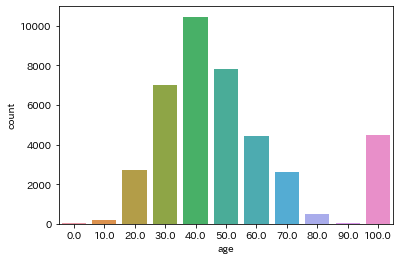

In [47]:
sns.countplot(user_df["age"])

In [48]:
s1 = set(meta_df["user_id"].unique())
s2 = set(user_df["user_id"].unique())
venn2(subsets=[s1,s2],set_labels=["meta_df", "user_df"])

In [49]:
def add_user_feature(input_df):
    _df = pd.merge(user_df, meta_df, on="user_id", how="left")[["session_id","gender","age"]]
    out_df = merge_by_session_id(input_df, _df)
    return out_df

In [50]:
add_user_feature(train_df)

gender    age
0          1.0   40.0
1          0.0   30.0
2          1.0   50.0
3          0.0   30.0
4          1.0   20.0
...        ...    ...
611372     9.0  100.0
611373     0.0   30.0
611374     0.0   20.0
611375     1.0   40.0
611376     1.0   50.0

[611377 rows x 2 columns]

In [51]:
add_user_feature(test_df)

gender   age
0         0.0  50.0
1         0.0  40.0
2         0.0  50.0
3         0.0  50.0
4         0.0  60.0
...       ...   ...
56481     1.0  20.0
56482     0.0  50.0
56483     0.0  20.0
56484     1.0  40.0
56485     0.0  40.0

[56486 rows x 2 columns]

In [65]:
# 見えているログ上で、どれだけ商品カテゴリを購入しているか
public_target_df, _ = create_target_from_log(use_for_train_log_df,
                            product_master_df,
                            only_payment=False,
                            target_flg=False)

In [66]:
public_target_df.tail()

252  253  254  255  256  257  258  259  260  261  262  263  265  \
session_id                                                                     
795922         0    0    0    0    0    0    0    0    0    0    0    0    0   
795924         0    0    0    0    0    0    0    0    0    0    0    0    0   
795927         0    0    0    0    0    0    0    0    0    0    0    0    0   
795932         0    0    0    0    0    0    0    0    0    0    0    0    0   
795933         0    0    0    0    0    0    0    0    0    0    0    0    0   

category_id  266  267  268  269  270  271  272  273  274  275  276  278  279  \
session_id                                                                     
795922         0    0    0    0    0    0    0    0    0    0    0    0    0   
795924         0    0    0    0    0    0    0    0    0    0    0    0    0   
795927         0    0    0    0    0    0    0    0    0    0    0    0    0   
795932         0    0    0    0    0    0    0    0    0    0    0    0    0   
795933         0    0    0    0    0    0    0    0    0    0    0    0    0   

category_id  280  281  283  284  285  286  287  288  289  290  291  292  294  \
session_id                                                                     
795922         0    0    0    0    0    0    0    0    0    0    0    0    0   
795924         0    0    0    0    0    0    0    0    0    0    0    0    0   
795927         0    0    0    0    0    0    0    0    0    0    0    0    0   
795932         0    0    0    0    0    0    0    0    0    0    0    0    0   
795933         0    0    0    0    0    0    0    0    0    0    0    0    0   

category_id  295  296  297  298  299  300  301  302  303  304  305  306  307  \
session_id                                                                     
795922         0    0    0    0    0    0    0    0    0    0    0    0    0   
795924         0    0    0    0    0    0    0    0    0    0    0    0    0   
795927         0    0    0    0    0    0    0    0    0    0    0    0    0   
795932         0    0    0    0    0    0    0    0    0    0    0    0    0   
795933         0    0    0    0    0    0    0    0    0    0    0    0    0   

category_id  308  309  310  311  312  313  314  315  316  317  319  321  322  \
session_id                                                                     
795922         0    0    0    0    0    0    0    0    0    0    0    0    0   
795924         0    0    0    0    0    0    0    0    0    0    0    0    0   
795927         0    0    0    0    0    0    0    0    0    0    0    0    0   
795932         0    0    0    0    0    0    0    0    0    0    0    0    0   
795933         0    0    0    0    0    0    0    0    0    0    0    0    0   

category_id  323  324  325  326  328  329  330  331  332  333  334  335  336  \
session_id                                                                     
795922         0    0    0    0    0    0    0    0    0    0    0    0    0   
795924         0    0    0    0    0    0    0    0    0    0    0    0    0   
795927         0    0    0    0    0    0    0    0    0    0    0    0    0   
795932         0    0    0    0    0    0    0    0    0    0    0    0    0   
795933         0    0    0    0    0    0    0    0    0    0    0    0    0   

category_id  338  339  340  341  342  343  344  345  346  347  348  349  352  \
session_id                                                                     
795922         0    0    0    0    1    1    0    0    0    0    0    0    0   
795924         0    0    0    0    0    0    0    0    0    0    0    0    0   
795927         0    0    0    0    0    0    0    0    0    0    0    0    0   
795932         0    0    0    0    0    0    0    0    0    0    0    0    0   
795933         0    0    0    0    0    0    0    0    0    0    0    0    0   

category_id  353  354  355  356  357  358  359  360  361  362  363  364  365  \
sessio

In [67]:
def add_log_feature(input_df):
    out_df = merge_by_session_id(input_df, public_target_df)
    return out_df

In [68]:
add_log_feature(train_df)

0    0    0    0   
1         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
611372    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611373    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611374    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611375    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611376    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

        451  452  453  454  455  456  457  458  459  460  461  462  463  464  \
0         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1         0    0    0    1    0    0    0    0    0    0    0    0    0    0   
2         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
611372    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611373    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611374    0    0    0    0    1    0    0    0    0    0    0    0    0    0   
611375    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611376    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

        465  466  467  468  469  470  471  472  473  474  475  476  477  478  \
0         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
611372    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611373    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611374    0    0    0    0    1    0    0    0    0    0    0    0    0    0   
611375    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611376    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

        479  480  484  486  487  488  489  490  491  492  493  494  495  496  \
0         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
611372    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611373    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611374    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611375    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
611376    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

        497  498  499  500  502  503  504  505  506  507  508  509  510  511  \
0         0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1         0    0    0    0    0    0    0    0    1    0    0    0    0    0   
2         0    0    0    0    0    0    0    0    0    0

In [69]:
add_log_feature(test_df)

0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56485  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       437  438  439  440  441  442  443  444  445  446  447  448  449  450  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
56481  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56482  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56483  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56484  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56485  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       451  452  453  454  455  456  457  458  459  460  461  462  463  464  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
56481  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56482  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56483  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56484  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56485  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       465  466  467  468  469  470  471  472  473  474  475  476  477  478  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
56481  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56482  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56483  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56484  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56485  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       479  480  484  486  487  488  489  490  491  492  493  494  495  496  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
56481  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56482  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56483  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56484  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
56485  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       497  498  499  500  502  503  504  505  506  507  508  509  510  511  \
0      0

In [70]:
# 特徴量生成器を結合させて動かす
def to_feature(input_df):
    processors = [
        add_log_feature,
        add_meta_feature,
        add_user_feature
    ]
    out_df = pd.DataFrame()
    for processor in processors:
        print(processor)
        out_df = pd.concat([out_df, processor(input_df)], axis=1)
    return out_df

In [71]:
train_df.shape , test_df.shape

((611377, 1), (56486, 1))

In [72]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

<function add_log_feature at 0x7fb842c39ef0>
<function add_meta_feature at 0x7fb820e98710>
<function add_user_feature at 0x7fb81a763710>
<function add_log_feature at 0x7fb842c39ef0>
<function add_meta_feature at 0x7fb820e98710>
<function add_user_feature at 0x7fb81a763710>


In [73]:
train_feat_df.head()

0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   74  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  92  93  94  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   95  96  97  98  99  108  109  110  111  112  113  114  115  116  118  119  \
0   0   0   0   0   0    0    0    0    0    0    0    0    0    0    0    0   
1   0   0   0   0   1    0    0    0    0    0    0    0    0    0    0    0   
2   0   0   0   0   0    0    0    0    0    0    0    0    0    0    0    0   
3   0   0   0   0   0    0    0    0    0    0    0    0    0    0    0    0   
4   0   0   0   0   0    0    0    0    0    0    0    0    0    0    0    0   

   120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   135  136  137  141  142  143  144  145  146  147  148  149  150  155  156  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   172  173  181  182  183  184  185  186  188  189  191  192  193  194  195  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0   

   211  212  213  214  215  216  217  218  219  220  221  222  223  224  225  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0 

In [74]:
train_target_df.head()

category_id  38   110  113  114  134  171  172  173  376  435  467  537  539  \
session_id                                                                     
0              0    0    0    0    0    0    0    0    0    0    0    0    0   
1              0    0    0    0    0    0    0    0    0    0    0    0    0   
2              0    0    0    0    0    0    0    0    0    0    0    0    0   
3              0    0    0    0    0    0    0    0    0    0    0    0    0   
5              0    0    0    0    0    0    0    0    0    0    0    0    0   

category_id  629  768  
session_id             
0              0    0  
1              0    0  
2              0    0  
3              0    0  
5              0    0

In [75]:
train_feat_df.shape, train_target_df.shape, test_feat_df.shape, test_df.shape

((611377, 676), (611377, 15), (56486, 676), (56486, 1))

## モデリング

In [76]:
# sklearn API方式（DataSet使っていない）

import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# X, y には、DataFrameでなく、numpyをいれる
# なので、df.valuesとする
def fit_lgbm(X, y, cv=None, params: dict=None, verbose=100):

    # パラメータがないときは、空のdictで置き換える
    if params is None:
        params = {}

    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True)

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float) # 関数を要確認！

    for i ,(idx_train, idx_valid) in enumerate(cv.split(X, y)):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)
        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)], #丸カッコも必要なの、なぜ？？
                early_stopping_rounds = verbose,
                eval_metric="logloss",
                verbose=verbose*2)

        pred_i = clf.predict_proba(x_valid)[:,1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f"Fold {i+1} AUC: {roc_auc_score(y_valid, pred_i):.4f}")
        print("-"*20)

    score = roc_auc_score(y, oof_pred)
    print(f"FINISHED \ whole score: {score:.4f}")

    return oof_pred, models, score

In [77]:
# 実験的に１つの目的変数（38）で回してみる
target_col_id = 38
y = train_target_df[target_col_id].values
y.mean()

0.06449375753422193

In [78]:
params = {
    'objective': 'binary',
    'learning_rate': .1,
    'max_depth': 6,
    'n_estimators': 10000,
    'colsample_bytree': .7,
    'importance_type': 'gain'
}

In [79]:
oof, models, score = fit_lgbm(train_feat_df.values, y, params=params)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.222372
[400]	valid_0's binary_logloss: 0.222164
[600]	valid_0's binary_logloss: 0.222122
Early stopping, best iteration is:
[527]	valid_0's binary_logloss: 0.222106
Fold 1 AUC: 0.6836
--------------------
Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.220919
[400]	valid_0's binary_logloss: 0.220669
Early stopping, best iteration is:
[422]	valid_0's binary_logloss: 0.22065
Fold 2 AUC: 0.6933
--------------------
Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.222687
[400]	valid_0's binary_logloss: 0.222494
Early stopping, best iteration is:
[445]	valid_0's binary_logloss: 0.222469
Fold 3 AUC: 0.6810
--------------------
Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.222885
[400]	valid_0's binary_logloss: 0.222588
Early stopping, best iteration is:
[

scoreへの値の入れ方を検証している

In [80]:
_df = pd.DataFrame()
_df["a"] = [1]
_df
_df["b"] = [2]

In [81]:
# feature_importanceも関数化しておくと便利
# 入力のかたちは決まっているので
# Foldごとのモデルの揺れも表現したく、sns.boxenplotを使用！
def visualize_importance(models, feat_train_df, plot_columns=50):
    """
    LightGBMのmodel配列の feature_importance を plot する
    CVごとのブレを sns.boxenplot として表現する 
    """

    feature_importance_df = pd.DataFrame()

    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df,_df], axis=0, ignore_index=True)

    # feature_importanceの合計値が大きい順に並び替えるためのlist
    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]].sort_values("feature_importance",ascending=False).index[:plot_columns]
    
    fig, ax = plt.subplots(figsize=(max(8,len(order)*.4), 7))
    sns.boxenplot(data=feature_importance_df,
                    x = "column",
                    y = "feature_importance",
                    order = order,
                    ax=ax,
                    palette = 'viridis')
    ax.tick_params(axis="x", rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df


In [83]:
models[0].feature_importances_.shape

(676,)

In [84]:
len(train_feat_df.columns)

676

In [180]:
fig,ax, _df = visualize_importance(models, train_feat_df,plot_columns=20)

In [185]:
id2category[38],id2category[40],id2category[40]

('アイスクリーム__ノベルティー', 'アイスクリーム__マルチ', '大型PET__炭酸（大型PET）')

In [181]:
_df.head()

feature_importance column  fold
0             0.00000      1     1
1             0.00000      2     1
2             0.00000      3     1
3            14.89291      4     1
4             0.00000      5     1

In [131]:
s_model = models[0]
s_model.predict_proba(test_feat_df.values) 

array([[0.95288512, 0.04711488],
       [0.9647681 , 0.0352319 ],
       [0.64117297, 0.35882703],
       ...,
       [0.89951728, 0.10048272],
       [0.9236002 , 0.0763998 ],
       [0.88828125, 0.11171875]])

In [135]:
pred = np.array([model.predict_proba(test_feat_df.values)[:,1] for model in models])
pred = np.mean(pred, axis=0) # 横方向にmean ※ np.meanの挙動チェック

### GOTOさんいわく、これは絶対みてほしいやつ
- 検証データと予測データで、結果の分布にズレがある（ので、特徴量づくりに工夫が必要そう）

<AxesSubplot:>

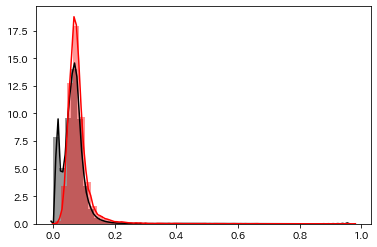

In [136]:
sns.distplot(oof, color="black")
sns.distplot(pred, color="red")

## 全カラムでの学習

In [148]:
def create_predict(models, feat_df):
    """
    与えられたモデルで予測を行う
    """
    pred = np.array([model.predict_proba(feat_df.values)[:,1] for model in models])
    pred = np.mean(pred, axis=0) # 横方向にmean ※ np.meanの挙動チェック
    return pred

id2category = dict(zip(product_master_df["category_id"], product_master_df["category_name"]))

oof_df, pred_df, cv_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for i, target_col_id in enumerate(TARGET_IDS):

    print(f"★ {i+1}/15 TARGET CATEGORY:{id2category[target_col_id]}")

    y = train_target_df[target_col_id].values
    oof, models, score = fit_lgbm(train_feat_df.values, y, params=params)
    pred = create_predict(models, test_feat_df)

    oof_df[target_col_id] = oof
    pred_df[target_col_id] = pred
    cv_df[target_col_id] = [score]


lid_0's binary_logloss: 0.238874
[400]	valid_0's binary_logloss: 0.23842
[600]	valid_0's binary_logloss: 0.238323
Early stopping, best iteration is:
[640]	valid_0's binary_logloss: 0.238307
Fold 4 AUC: 0.7133
--------------------
Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.238707
[400]	valid_0's binary_logloss: 0.238312
[600]	valid_0's binary_logloss: 0.238195
[800]	valid_0's binary_logloss: 0.23817
Early stopping, best iteration is:
[706]	valid_0's binary_logloss: 0.238116
Fold 5 AUC: 0.7130
--------------------
FINISHED \ whole score: 0.7133
★ 2/15 TARGET CATEGORY:ビール系__ビール系
Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.257884
[400]	valid_0's binary_logloss: 0.257461
[600]	valid_0's binary_logloss: 0.257393
Early stopping, best iteration is:
[522]	valid_0's binary_logloss: 0.257354
Fold 1 AUC: 0.6894
--------------------
Training until validation scores don't improve for 100 rounds
[

In [151]:
cv_df

Empty DataFrame
Columns: [171, 173, 172, 114, 134, 110, 113, 38, 376, 537, 539, 629, 467, 435, 768]
Index: []

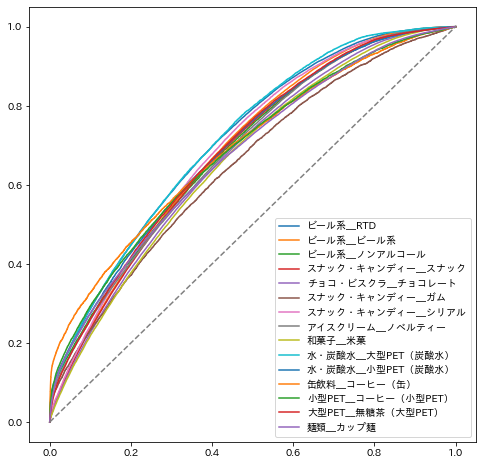

In [160]:
from sklearn.metrics import roc_curve
fig, ax = plt.subplots(figsize=(8,8))
for c in TARGET_IDS:
    fpr, tpr, _ = roc_curve(train_target_df[c], oof_df[c])
    ax.plot(fpr, tpr, label=id2category[c])
ax.legend()
ax.plot(np.linspace(0,1), np.linspace(0,1), "--", color="gray")

In [149]:
pred_df.to_csv(os.path.join(OUTPUT_DIR, "210206_01.csv"), index=False)